In [1]:
import symforce
symforce.set_epsilon_to_symbol()

In [2]:
import numpy as np
from symforce.values import Values

import rosbag2_py
from rclpy.serialization import deserialize_message

In [3]:
bag_path = "../bags/dataset_drive_square_no_vid"
# Copied the following from https://qiita.com/nonanonno/items/8f7bce03953709fd5af9
storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id="sqlite3")
converter_options = rosbag2_py.ConverterOptions(input_serialization_format="cdr", output_serialization_format="cdr")

sr = rosbag2_py.SequentialReader()
sr.open(storage_options, converter_options)
sr.set_filter(rosbag2_py.StorageFilter(topics=["/odom", "/detections", "/camera/camera_info"]))

[INFO] [1698691007.324500612] [rosbag2_storage]: Opened database '../bags/dataset_drive_square_no_vid/rosbag2_2023_10_25-11_14_04_0.db3' for READ_ONLY.


In [4]:
# Create a dictionary of each topic's message type
# This will be used for deserializing the messages.
import importlib
def get_type_from_str(type_str: str):
    # dynamic load message package
    pkg = importlib.import_module(".".join(type_str.split("/")[:-1]))
    return eval(f"pkg.{type_str.split('/')[-1]}")

msg_type_table = {}
for topic in sr.get_all_topics_and_types():
    msg_type_table[topic.name] = get_type_from_str(topic.type)

In [5]:
# Now we extract messages from the entire bag
sr.seek(0)
msgs = []
while sr.has_next():
    msgs.append(sr.read_next())

msgs_no_cam = [msg for msg in msgs if not (msg[0] == "/camera/camera_info")]

[INFO] [1698691007.484943617] [rosbag2_storage]: Opened database '../bags/dataset_drive_square_no_vid/rosbag2_2023_10_25-11_14_04_0.db3' for READ_ONLY.


In [6]:
# Extract detections and odometry messages
f_deserialize_msg = lambda msg: deserialize_message(msg[1], msg_type_table[msg[0]])
def get_first_msg_of_topic(topic):
    return next(deserialize_message(msg[1], msg_type_table[msg[0]]) for msg in msgs if msg[0] == topic)

example_odom_data = get_first_msg_of_topic("/odom")
example_detections_data = get_first_msg_of_topic("/detections")
example_camera_info_data = get_first_msg_of_topic("/camera/camera_info")

print(example_odom_data)
print("---")
print(example_detections_data)
print("---")
print(example_camera_info_data)

nav_msgs.msg.Odometry(header=std_msgs.msg.Header(stamp=builtin_interfaces.msg.Time(sec=1697911413, nanosec=507019835), frame_id='odom'), child_frame_id='base_footprint', pose=geometry_msgs.msg.PoseWithCovariance(pose=geometry_msgs.msg.Pose(position=geometry_msgs.msg.Point(x=0.002499930899425671, y=2.0161891289617244e-06, z=0.0), orientation=geometry_msgs.msg.Quaternion(x=0.0, y=0.0, z=-0.010080474430627446, w=0.9999491907268356)), covariance=array([1.e-01, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-01,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-01, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+05, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+05, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 1.e+05])), twist=geometry_msgs.msg.TwistWithCovariance(twist=geometry_msgs.msg.Twist(linear=geometry_msgs.msg.Vector3(x=0.0, y=0.0, z=0.0), angular=geometry_msgs.msg.Vector3(x=0.0, y=0.0, z=0.0)), covariance=array([0., 0., 0., 0., 0., 0., 

In [7]:
import symforce.symbolic as sf
# Get the example messages into np form to play around with them
example_corners = np.array([
    np.array([corner.x, corner.y])
    for corner in example_detections_data.detections[0].corners
])

camera_K = np.reshape(example_camera_info_data.k, (3, 3))
focal_length = [camera_K[0, 0], camera_K[1, 1]]
principal_point = [camera_K[0, 2], camera_K[1, 2]]
camera_cal = sf.LinearCameraCal(focal_length=focal_length, principal_point = principal_point)

In [8]:
## Phase 1: Integrate odometry using Symforce?
# Define the odometry residual function?
from symforce.codegen.geo_factors_codegen import prior_factor, between_factor

def residual_between(pose_1: sf.Pose3, pose_2: sf.Pose3, rdelta_measured: sf.Pose3, epsilon: sf.Scalar):
    # Compute the expected body-frame displacement
    # pose_1 * rdelta = pose_2
    rdelta_expected = pose_1.inverse() * pose_2

    # The "error": rdelta_expected ⊟ rdelta_measured
    error = rdelta_measured.local_coordinates(rdelta_expected, epsilon)
    return error

def get_tag_corner_residual(i_corner: np.int_):
    ## Get the position of the tags in the camera frame
    # Define the displacements from the tag center to each tag corner
    R = sf.Rot3.identity()
    w = 0.203
    # Corner order: start in bottom left (-x, -y) and go ccw
    g_tag_c1 = sf.Pose3(R, sf.Vector3([-w/2, -w/2, 0]))
    g_tag_c2 = sf.Pose3(R, sf.Vector3([-w/2, w/2, 0]))
    g_tag_c3 = sf.Pose3(R, sf.Vector3([w/2, w/2, 0]))
    g_tag_c4 = sf.Pose3(R, sf.Vector3([w/2, -w/2, 0]))
    g_tag_corners = [g_tag_c1, g_tag_c2, g_tag_c3, g_tag_c4]
    g_tag_ci = g_tag_corners[i_corner]

    def residual_tag_obs(camera_pose: sf.Pose3, tag_pose: sf.Pose3, corners_px_measured: sf.M12, epsilon: sf.Scalar):
        # Measure the error between the expected pixel coordinates of the tag corners
        # versus the actual measured ones.
    
        # Compute the expected tag corner positions in the camera frame
        # based on the hypothesized camera and tag poses.
        g_cam_tag = camera_pose.inverse() * tag_pose
        g_cam_corner = g_cam_tag * g_tag_ci
    
        # Project the tag corner positions into the camera frame using the camera model
        corners_px_expected = camera_cal.pixel_from_camera_point(g_cam_corner.t)[0]
    
        return corners_px_measured.T - corners_px_expected
    return residual_tag_obs
    

In [69]:
from symforce.opt.factor import Factor
from symforce.values import Values

start_factor = 300
n_factors = 2000
tag_ids = [0, 1, 2, 3, 4, 5]

# Supporting functions
def pose3_msg_to_sf(msg):
    q_xyz = [msg.orientation.x, msg.orientation.y, msg.orientation.z]
    w = msg.orientation.w
    quat = sf.Quaternion(xyz=sf.Vector3(q_xyz), w=w)
    R = sf.Rot3(quat)

    posn = [msg.position.x, msg.position.y, msg.position.z]
    t = sf.Vector3(posn)
    return sf.Pose3(R, t)

## Initialize storage vars
factors = []
# Store odometry sensor data
i_pose = 0
odoms = []
last_pose = sf.Pose3.identity()
# Store tag detections
n_detections = [0 for id in tag_ids]
detections = [[] for id in tag_ids]
#n_detections = {id: 0 for id in tag_ids}
#detections = {id: [] for id in tag_ids}
#tag_poses = {id: [[]] for id in tag_ids}
for i in range(start_factor, start_factor + n_factors):
    topic, bdata, time = msgs_no_cam[i]
    data = f_deserialize_msg(msgs_no_cam[i])

    if topic == "/odom":
        ## Add a between-factor to the factor graph
        factors.append(Factor(
            residual=residual_between,
            keys=[f"poses[{i_pose}]", f"poses[{i_pose+1}]", f"odoms[{i_pose}]", "epsilon"]
        ))

        ## Record the sensor data into the list of displacements
        pose = pose3_msg_to_sf(data.pose.pose)
        if i_pose == 0:
            # If first displacement measurement, simply record 0
            odoms.append(sf.Pose3.identity())
            last_pose = pose
        else:
            # Otherwise, record the displacement from the last pose
            # last_pose * delta = pose
            # => delta = inv(last_pose) * pose
            delta = last_pose.inverse() * pose
            odoms.append(delta)
        i_pose = i_pose + 1
        
    elif topic == "/detections":
        pass
        # for detection in data.detections:
        #     tag_id = detection.id
            
        #     corners_i = []
        #     for i, corner in enumerate(detection.corners):
        #         factors.append(Factor(
        #             residual=get_tag_corner_residual(i),
        #             keys=[
        #                 f"poses[{i_pose}]",
        #                 f"tag_poses[{tag_id}][{n_detections[tag_id]}]",
        #                 f"detections[{tag_id}][{n_detections[tag_id]}][{i}]",
        #                 "epsilon"
        #             ]
        #         ))

        #         corners_i.append(sf.M12([corner.x, corner.y]))
        #     detections[tag_id].append(corners_i)
        #     # Count a new detection for this tag
        #     n_detections[tag_id] += 1

n_poses = i_pose + 1
initial_poses = [sf.Pose3.identity()] * n_poses
initial_tag_poses = [[sf.Pose3.identity()] * n_detections[id] for id in tag_ids]

for i, detection_list in enumerate(detections):
    if n_detections[i] == 0:
        detections[i] = [[0]]
        initial_tag_poses[i] = [sf.Pose3.identity()]

initial_values = Values(
    poses = initial_poses,
    odoms = odoms,
    detections = detections,
    tag_poses = initial_tag_poses,
    epsilon = sf.numeric_epsilon
)

In [70]:
from symforce.opt.optimizer import Optimizer

optimizer = Optimizer(
    factors=factors,
    optimized_keys=[f"poses[{i}]" for i in range(n_poses)],
    # So that we save more information about each iteration, to visualize later:
    debug_stats=True,
)
result = optimizer.optimize(initial_values)

[2023-10-30 15:22:39.205] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 2.261e+03/0.000e+00/2.228e+03, rel reduction: 1.48050e-02
[2023-10-30 15:22:39.220] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 2.228e+03/0.000e+00/2.164e+03, rel reduction: 2.84259e-02
[2023-10-30 15:22:39.236] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 2.164e+03/0.000e+00/2.116e+03, rel reduction: 2.23931e-02
[2023-10-30 15:22:39.252] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 2.116e+03/0.000e+00/3.053e+03, rel reduction: -4.42736e-01
[2023-10-30 15:22:39.269] [info] LM<sym::Optimize> [iter    4] lambda: 6.250e-02, error prev/linear/new: 2.116e+03/0.000e+00/3.168e+03, rel reduction: -4.97241e-01
[2023-10-30 15:22:39.285] [info] LM<sym::Optimize> [iter    5] lambda: 2.500e-01, error prev/linear/new: 2.116e+03/0.000e+00/2.675e+03, rel reduction: -2.64521e-01
[2023-10-30 15:22:3

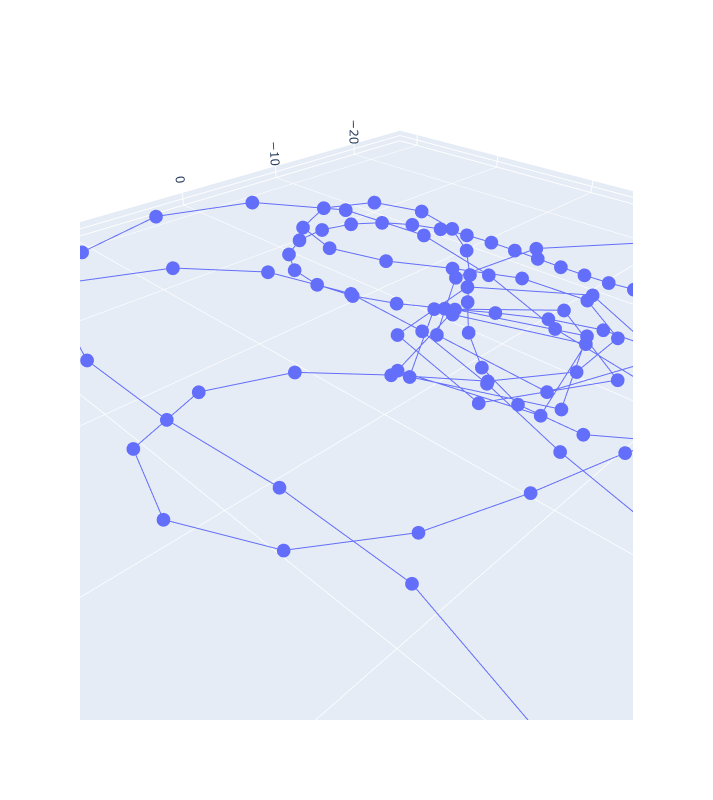

In [73]:
import plotly.graph_objects as go

robot_poses_optimized = result.optimized_values["poses"]
robot_t_optimized = np.array([pose.t for pose in robot_poses_optimized], dtype=np.float32)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x = robot_t_optimized[:, 0],
    y = robot_t_optimized[:, 1],
    z = robot_t_optimized[:, 2],
))
fig.update_layout(width=800, height=800, scene_aspectmode="data")

In [ ]:
# TODOS:
# 1. Initialize the pose estimates using integrated odometry measurements
# 2. Diagram and think through how to handle tag detections coming 
#    in at a higher rate than the odometry